# HOLStep Dataset Feature Generation and EDA Notebook

## Importing All Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Load the data to a pandas DataFrame from the modified master dataset; includes all test and training samples as provided by the authors of the HOLStep paper. Master.txt was generated by running fileConvertScript.py and combineToMaster.py scripts.

In [2]:
my_dir = 'G:\\'
df = pd.read_csv(my_dir + 'master.txt', delimiter=';')
print(df.head())

      conj_name         dep_name  depen_bin  \
0  Ssrnat.subSS            TRUTH          1   
1  Ssrnat.subSS           ETA_AX          1   
2  Ssrnat.subSS  EXCLUDED_MIDDLE          1   
3  Ssrnat.subSS    BOOL_CASES_AX          1   
4  Ssrnat.subSS    DE_MORGAN_THM          1   

                                          step_token  useful_bin  
0                                                 cT           1  
1                                    c= / * f0 b0 f0           1  
2                                       c\/ f0 c~ f0           1  
3                              c\/ c= f0 cT c= f0 cF           1  
4  c/\ c= c~ c/\ f0 f1 c\/ c~ f0 c~ f1 c= c~ c\/ ...           1  


## Show the types of data in this DataFrame, number of observations and features

In [3]:
df.dtypes

conj_name     object
dep_name      object
depen_bin      int64
step_token    object
useful_bin     int64
dtype: object

In [4]:
df.shape

(2537139, 5)

## Produce a simple bar chart of the top 20 longest proofs

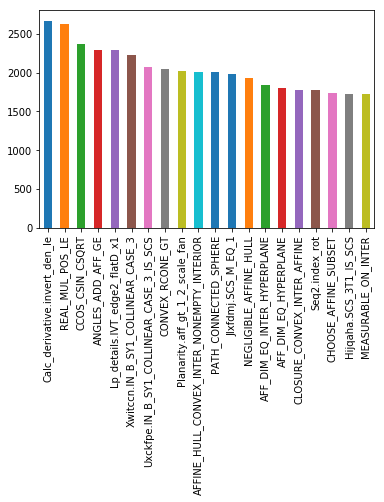

In [5]:
df['conj_name'].value_counts().head(20).plot.bar()
plt.show()

## Produce a simple bar chart of the top 20 most popular Dependencies

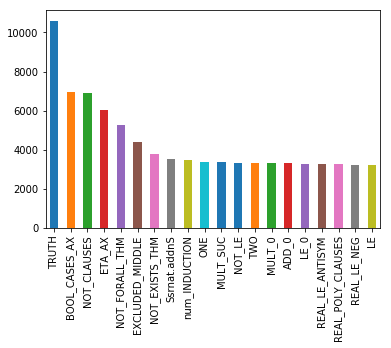

In [6]:
df['dep_name'].value_counts().head(20).plot.bar()
plt.show()

## Isolate the Dependencies and the conjecture to which they belong

In [7]:
dep_only = df['depen_bin'] == 1

In [8]:
df_dep_only = df[dep_only]

In [9]:
df_dep_only.head()

,conj_name,dep_name,depen_bin,step_token,useful_bin
0,Ssrnat.subSS,TRUTH,1,cT,1
1,Ssrnat.subSS,ETA_AX,1,c= / * f0 b0 f0,1
2,Ssrnat.subSS,EXCLUDED_MIDDLE,1,c\/ f0 c~ f0,1
3,Ssrnat.subSS,BOOL_CASES_AX,1,c\/ c= f0 cT c= f0 cF,1
4,Ssrnat.subSS,DE_MORGAN_THM,1,c/\ c= c~ c/\ f0 f1 c\/ c~ f0 c~ f1 c= c~ c\/ ...,1


In [10]:
df_dep_only.shape

(328063, 5)

In [11]:
df_dep_only = df_dep_only[['conj_name', 'step_token']]

In [12]:
df_dep_only.head()

,conj_name,step_token
0,Ssrnat.subSS,cT
1,Ssrnat.subSS,c= / * f0 b0 f0
2,Ssrnat.subSS,c\/ f0 c~ f0
3,Ssrnat.subSS,c\/ c= f0 cT c= f0 cF
4,Ssrnat.subSS,c/\ c= c~ c/\ f0 f1 c\/ c~ f0 c~ f1 c= c~ c\/ ...


## Generate the Dependency Document for each conjecture by joining all Dependency text tokenizations into a single string and grouping by conjecture name

In [13]:
df_dep_only['text'] = df_dep_only[['conj_name', 'step_token']].groupby(['conj_name'])['step_token'].transform(lambda x: ' '.join(x))
df_dep_only = df_dep_only[['conj_name', 'text']].drop_duplicates()

In [14]:
df_dep_only.head()

,conj_name,text
0,Ssrnat.subSS,cT c= / * f0 b0 f0 c\/ f0 c~ f0 c\/ c= f0 cT c...
622,REAL_TRUNCATE,cT c= / * f0 b0 f0 c\/ f0 c~ f0 c\/ c= f0 cT c...
1282,Leaf_cell.WEDGE_COMPLEMENT,cT c\/ c= f0 cT c= f0 cF c/\ ! c= c~ c~ b0 b0 ...
1463,Jejtvgb.JEJTVGB_case_breakdown,cT c/\ c= cMEM f0 cNIL cF c= cMEM f0 cCONS f1 ...
1505,HAS_REAL_INTEGRAL_NULL,cT c= / * f0 b0 f0 c\/ c= f0 cT c= f0 cF c/\ !...


In [15]:
df_dep_only.shape

(11410, 2)

## Vectorize the Dependency Documents for each conjecture then generate a TFIDF matrix to give importance to relevant tokens while diminishing importance of common stop tokens

In [16]:
vectorizer = CountVectorizer()
vectorized_text = vectorizer.fit_transform(df_dep_only['text'])
df_dep_only['text_vector'] = list(vectorized_text)

In [17]:
tfidf_transformer = TfidfTransformer()
transformed_text_tfidf = tfidf_transformer.fit_transform(vectorized_text)
transformed_text_tfidf.shape

(11410, 1820)

## Perform Principal Component Analysis with two principal components on Dependency Document TFIDF matrix 

In [18]:
pca = PCA(n_components=2)
pca.fit(transformed_text_tfidf.toarray())
X_pca = pca.transform(transformed_text_tfidf.toarray())

In [19]:
pca.explained_variance_ratio_

array([0.16650666, 0.06297308])

## Set an output directory for visualizations

In [20]:
output_dir = "C:\\Users\\Vin\\Desktop\\Masters Degree\\WPI - Data Science\\05 - Big Data Analytics\\Final Project\\Documentation\\Figures\\"

## Build, display, and save Dependency Document PCA visualization

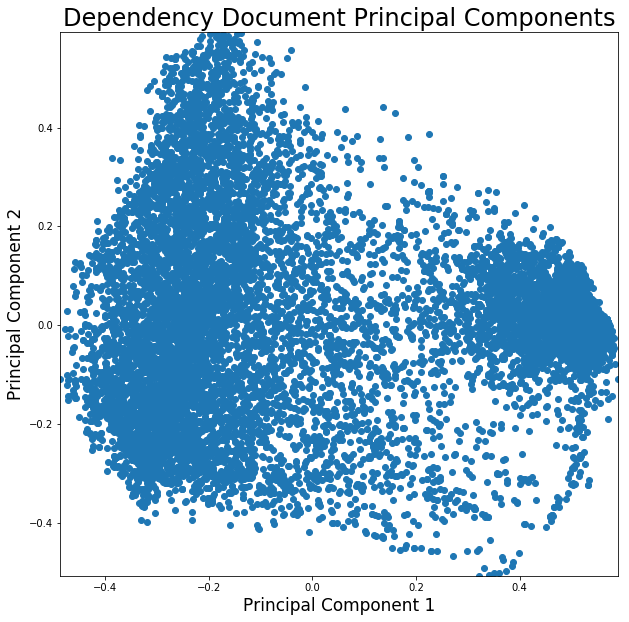

In [21]:
fig = plt.figure(figsize=(10,10))
plt.xlim(X_pca[:,0].min(), X_pca[:,0].max())
plt.ylim(X_pca[:,1].min(), X_pca[:,1].max())

x = X_pca[:,0]
y = X_pca[:,1]

plt.title("Dependency Document Principal Components", fontsize=24)
plt.xlabel("Principal Component 1", fontsize=17)
plt.ylabel("Principal Component 2", fontsize=17)
plt.scatter(x, y)
plt.savefig(output_dir + "DD_PCA_fig.png", dpi=600, format='png')
plt.show()

## Begin kMeans clustering analysis by investigating Sum of Squared Errors (SSE) reductions achieved by 1 to 20 clusters on Dependency Document PCA results

In [22]:
ssd = np.array([])
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=2018)
    kmeans.fit(X_pca)
    ssd = np.append(ssd, kmeans.inertia_)

In [23]:
ssd = pd.DataFrame(ssd)
ssd['Clusters'] = range(1, 21)
ssd.columns = ['SSD', 'Clusters']

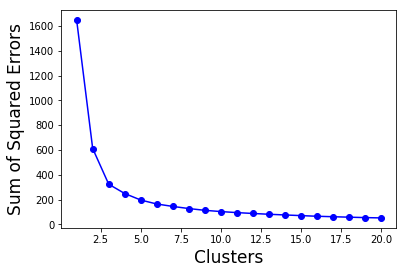

In [24]:
plt.plot(ssd.iloc[:,1], ssd.iloc[:,0], 'b-o')
plt.xlabel('Clusters', fontsize=17)
plt.ylabel('Sum of Squared Errors', fontsize=17)
plt.savefig(output_dir + "DD_kmeans_.png", dpi=600, format='png')

## Show kMeans clustering result for six clusters, which appears to reduce SSE substantially without overfitting

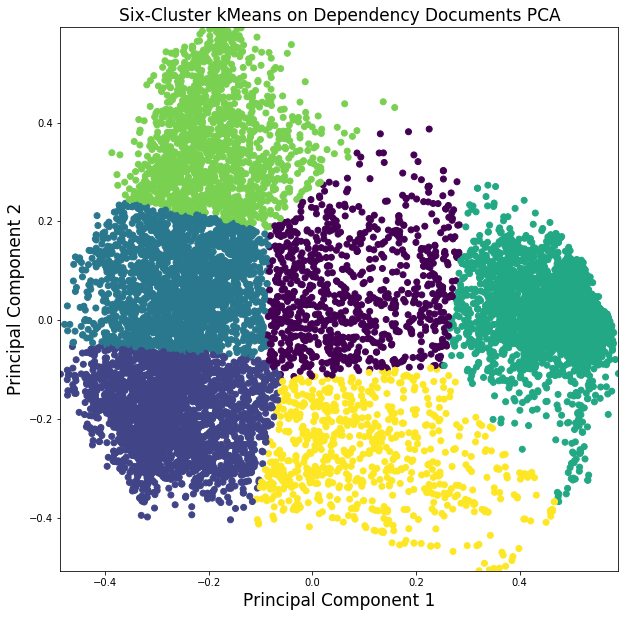

In [25]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_pca)
plt.figure(figsize=(10, 10))
plt.xlim(X_pca[:,0].min(), X_pca[:,0].max())
plt.ylim(X_pca[:,1].min(), X_pca[:,1].max())
plt.title("Six-Cluster kMeans on Dependency Documents PCA", fontsize=17)
plt.xlabel("Principal Component 1", fontsize=17)
plt.ylabel("Principal Component 2", fontsize=17)
plt.scatter(x, y, c = kmeans.labels_)
plt.savefig(output_dir + "DD_PCA_kmeans_fig.png", dpi=600, format='png')

## Perform t-Distributed Stochastic Neighbor Embedding (t-SNE) analysis on Dependency Document TFIDF matrix

In [26]:
tsne = TSNE(random_state=2018)
deps_tsne = tsne.fit_transform(transformed_text_tfidf.toarray())

In [27]:
tsne

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=2018, verbose=0)

## Build, display, and save Dependency Document t-SNE visualization

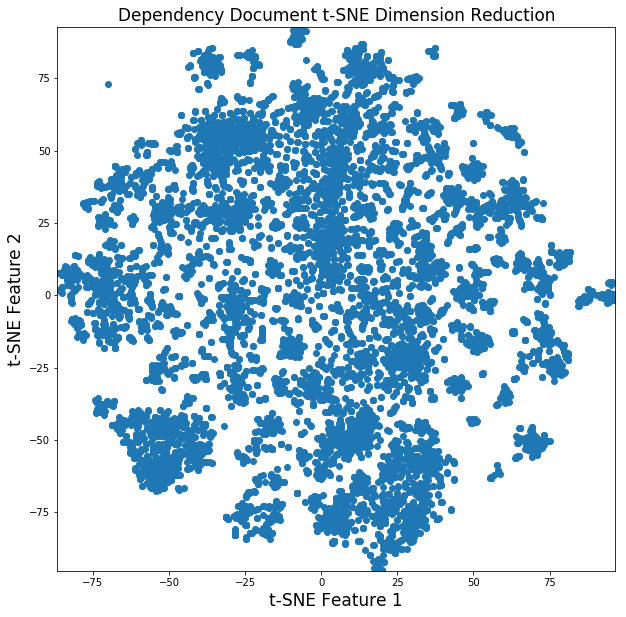

In [28]:
plt.figure(figsize=(10,10))
plt.xlim(deps_tsne[:,0].min(), deps_tsne[:,0].max())
plt.ylim(deps_tsne[:,1].min(), deps_tsne[:,1].max())
plt.title("Dependency Document t-SNE Dimension Reduction", fontsize=17)
plt.xlabel("t-SNE Feature 1", fontsize=17)
plt.ylabel("t-SNE Feature 2", fontsize=17)
plt.scatter(deps_tsne[:,0], deps_tsne[:,1])
plt.savefig(output_dir + "DD_tsne.png", dpi=600, format='png')

## Begin kMeans clustering analysis by investigating Sum of Squared Errors (SSE) reductions achieved by 1 to 30 clusters on Dependency Document t-SNE results

In [29]:
ssd_tsne = np.array([])
for k in range(1,31):
    kmeans = KMeans(n_clusters=k, random_state=2018)
    kmeans.fit(deps_tsne)
    ssd_tsne = np.append(ssd_tsne, kmeans.inertia_)

In [30]:
ssd_tsne = pd.DataFrame(ssd_tsne)
ssd_tsne['Clusters'] = range(1,31)
ssd_tsne.columns = ['SSD', 'Clusters']

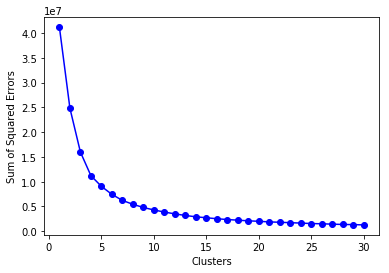

In [31]:
plt.plot(ssd_tsne.iloc[:,1], ssd_tsne.iloc[:,0], 'b-o')
plt.xlabel("Clusters")
plt.ylabel("Sum of Squared Errors")
plt.savefig(output_dir + "DD_tsne_KM_error.png", dpi=600, format='png')

## Show kMeans clustering result for 15 clusters, which appears to reduce SSE substantially without overfitting

In [32]:
kmeans_tsne = KMeans(n_clusters=15)
kmeans_tsne.fit(deps_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

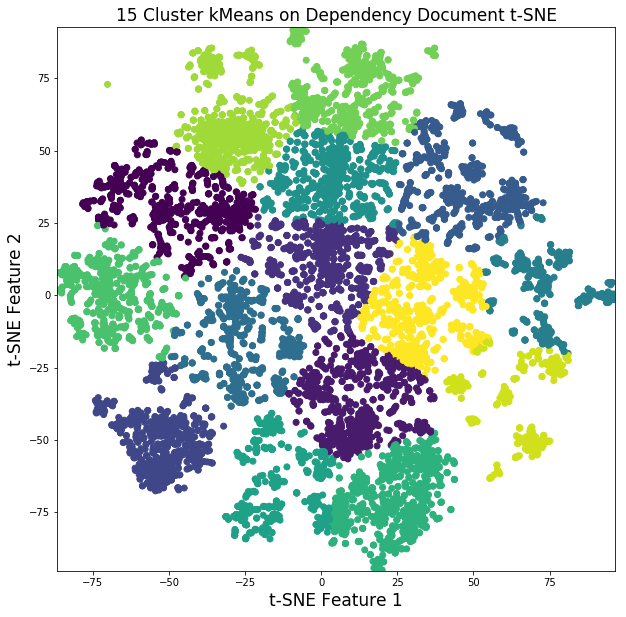

In [33]:
plt.figure(figsize=(10,10))
plt.xlim(deps_tsne[:,0].min(), deps_tsne[:,0].max())
plt.ylim(deps_tsne[:,1].min(), deps_tsne[:,1].max())
plt.title("15 Cluster kMeans on Dependency Document t-SNE", fontsize=17)
plt.xlabel("t-SNE Feature 1", fontsize=17)
plt.ylabel("t-SNE Feature 2", fontsize=17)
plt.scatter(deps_tsne[:,0], deps_tsne[:,1], c=kmeans_tsne.labels_)
plt.savefig(output_dir + "DD_tsne_KM.png", dpi=600, format='png')

## Load data generated by two principal component PCA run on Intermediate Proof Step data in Apache Spark on AWS EMR using a three-m3.xlarge instance configuration. Apache Spark pyspark code in file spark_code.txt. Results stitched together from 32 Spark output files using sparkStitch.py.

In [34]:
my_dir = 'G:\\'
step_df = pd.read_csv(my_dir + 'spark_results.csv')
print(step_df.head())
step_df.dtypes

       PC1      PC2  useful
0  12.8362 -56.5203       1
1   9.1078 -37.3211       1
2   2.1016 -22.0255       0
3   5.6558 -36.1636       0
4   7.6781 -32.9131       1


PC1       float64
PC2       float64
useful      int64
dtype: object

## Build, plot, and save Intermediate Proof Step two principal component PCA visualiztion

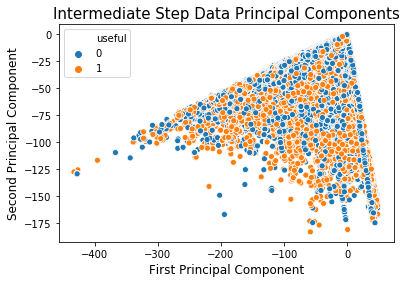

In [35]:
sns.scatterplot(x='PC1', y='PC2', hue='useful', data=step_df)
plt.title("Intermediate Step Data Principal Components", fontsize=15)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12)
plt.savefig(output_dir + "IS_PCA_fig.png", dpi=600, format='png')

## Load data generated by three principal component PCA run on Intermediate Proof Step data. Methodology was identical to two principal component PCA. 

In [36]:
step_3d_df = pd.read_csv(my_dir + 'spark_3d_results.csv')

## Build, plot, and save Intermediate Proof Step three principal component PCA visualiztion

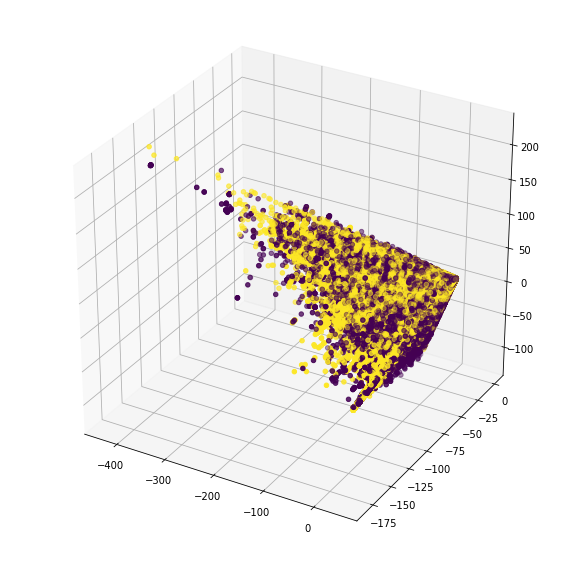

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(step_3d_df['PC1'], step_3d_df['PC2'], step_3d_df['PC3'], c=step_3d_df['useful'])
plt.savefig(output_dir + "IS_PCA3_fig.png", dpi=600, format='png')